<a id="outlines"></a>

------------------------------------------
------------------------------------------
------------------------------------------
<h2 align="center" style='color:#0077EE'>Data Preprocessing</h2><br> 

------------------------------------------
------------------------------------------
------------------------------------------
<h1><span>&#8226;</span> Outline:</h1>
<ul>
    <li><a href="#gather_data">Gathering the data</a>
    <li><a href="#EDA">Look at the data</a>  
    <li><a href="#stationarity">Data stationarity analysis</a>
        <ul>
            <li><a href="#test">Test for Stationarity</a>
            <li><a href="#data_trans">Apply some data transformation for Stationarity</a>   
        </ul>
    <li><a href="#decomposition ">TS Decomposition</a>
    <li><a href="#corr">See the Correlation between Our Time Series.</a>
    <li><a href="#acf_pacf">Plot the ACF & PACF For the data.</a>
    <li><a href="#forecasting">Forecasting</a>
        <ul>
            <li><a href="#auto_arima">Auto ARIMA model</a>

<a id="gather_data"></a>
<h1>Gathering the data</h1><br>
The used data is from  <a href='https://pypi.org/project/yfinance/'><b>yfinance<a/>

In [48]:
import numpy as np
import pandas as pd
import yfinance
import warnings
import cufflinks as cf
from plotly.offline import init_notebook_mode
import plotly.io as pio
from IPython.display import Image, display
from  scipy.stats import  boxcox
import plotly.graph_objs as go
from plotly.subplots import make_subplots 
import seaborn as sns
import matplotlib.pyplot as plt

from utils.utils import plot_hist, plot_line, create_corr_plot, test_stationarity, seasonal_decompose

In [2]:
# It's a Pythonic way to download historical market data from Yahoo! finance.
raw_data = yfinance.download(tickers='^GSPC ^FTSE ^N225 ^GDAXI', start='2010-01-01', ends='2020-01-01',
                             interval='1d', group_by='tickers', auto_adjust=True, treads=True)

df_comp = raw_data.copy()

df_comp['sequence'] = df_comp['^FTSE'].Close[:]
df_comp['gdaxi'] = df_comp['^GDAXI'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
df_comp['gspc'] = df_comp['^GSPC'].Close[:]

df_comp = df_comp.iloc[4:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']


#Convert TimeSeries to specified frequency.
#Using “b” tells Python to expect missing values when the date falls on a Saturday or a Sunday.(only business days)
df_comp=df_comp.asfreq('b') #b=business days, d=days, m=month ....etc

#'ffill' stands for "forward fill" and it takes the last value preceding the null value and fills it.
df_comp = df_comp.fillna(method='ffill')

#Convert the Date to Datetime and set in as TS index
df_comp = df_comp.reset_index()
df_comp['Date'] = pd.to_datetime(df_comp['Date'], dayfirst=True)
df_comp.set_index('Date', inplace=True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp.head()

sequence        gdaxi        nikkei         gspc
                                                               
Date                                                           
2010-01-07  5526.700195  6019.359863  10681.660156  1141.689941
2010-01-08  5534.200195  6037.609863  10798.320312  1144.979980
2010-01-11  5538.100098  6040.500000  10798.320312  1146.979980
2010-01-12  5498.700195  5943.000000  10879.139648  1136.219971
2010-01-13  5473.500000  5963.140137  10735.030273  1145.680054

<a href="#outlines">Back to outlines</a><br>

<a id="EDA"></a>
## Look at the data

>Lets deal with sequence as our TS data.(Endogenous)<br>
>We can use the other data as exongeous variables.

In [4]:
df_comp.reset_index().describe(datetime_is_numeric=True)

Date     sequence         gdaxi        nikkei  \
                                                                                
count                           3246  3246.000000   3246.000000   3246.000000   
mean   2016-03-27 21:35:49.353049856  6569.653053  10414.205365  17817.939673   
min              2010-01-07 00:00:00  4805.799805   5072.330078   8160.009766   
25%              2013-02-15 18:00:00  5954.200195   7709.325195  11360.082764   
50%              2016-03-28 12:00:00  6669.800049  10632.685059  18399.905273   
75%              2019-05-07 18:00:00  7184.949951  12543.397217  22258.730469   
max              2022-06-16 00:00:00  7877.500000  16271.750000  30670.099609   
std                              NaN   706.345475   2844.745367   6172.468765   

              gspc  
                    
count  3246.000000  
mean   2337.008440  
min    1022.580017  
25%    1515.697479  
50%    2100.419922  
75%    2864.195068  
max    4796.560059  
std     956.850335

In [5]:
# plot_line(df_comp, ['sequence','nikkei','gdaxi','gspc'])

<img src="results/MLP_1.png">

#### Missing values

In [6]:
df_comp.isna().sum()

sequence      0
gdaxi         0
nikkei        0
gspc          0
dtype: int64

#### Splitting the Data


In [67]:
size = int(len(df_comp)*0.7)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

><b><li>Non shuffling with TS

<a href="#outlines">Back to outlines</a><br>

<a id="stationarity"></a>
## Look at stationarity
Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.
Sometimes we need to transform the data in order to make it stationary.<br>We can check stationarity using these techniques:

<a id="test"></a>
**Testing the stationarity:**
- Rolling mean and standard deviation and look if they are changing over time. 
- Apply Dickey-Fuller test or KPSS test, and see if we can reject the null hypothesis (that the time series is stationary)

A major difference between KPSS and ADF tests is the capability of the KPSS test to check for stationarity in the 'presence of a deterministic trend'.<br>
The word ‘deterministic’ implies the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path.

In [68]:
test_stationarity(df, 'sequence', 'Sequence')

===>Results of Dickey-Fuller Test for sequence:

Test Statistic                   -1.710484
p-value                           0.425719
# Lags Used                       4.000000
Number of Observations Used    2266.000000
Critical Value (1%)              -3.433239
Critical Value (5%)              -2.862816
Critical Value (10%)             -2.567449
dtype: float64
Result: The series is not stationary


<img src='results/MLP_3.png'>

**From The Results:**
- We can see that the p-value is **0.93**. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.
- The Rolling mean is not constant.
- The Rolling variance is not constant.

So, we need to deal with non-stationarity and trend before applying state-space models or even ML models.
We can deal with non-stationarity in TS by various methods:
- Transformation (e.g Log, Square Root, Differencing,...).
- Smoothing (Weakly average, monthly average, Rolling average,...).
- Polynomial fitting (fitting a regression model).
- Decompositions.

<a id="data_trans"></a>
<h3>Let's apply some transformation methods and check the seasonality for each of them

========== Sequence differencing ==========
===>Results of Dickey-Fuller Test for seq_diff:

Test Statistic                  -20.804843
p-value                           0.000000
# Lags Used                       7.000000
Number of Observations Used    3237.000000
Critical Value (1%)              -3.432372
Critical Value (5%)              -2.862433
Critical Value (10%)             -2.567246
dtype: float64
Result: The series is stationary


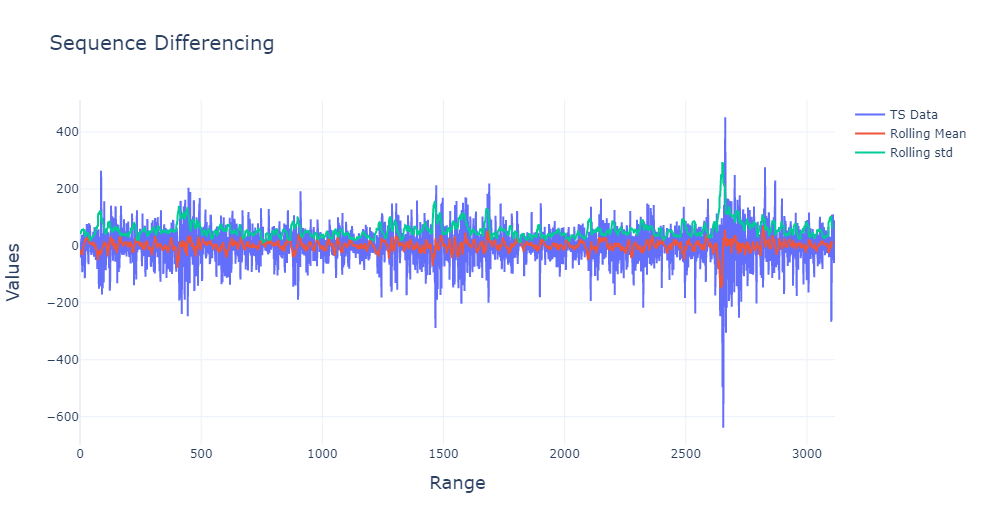

In [15]:
stat_values = {}

#====>Sequence differencing
print('='*10,'Sequence differencing','='*10)
# Transformation 
df['seq_diff'] = df['sequence'].diff()
# Perform stationarity test
stat_values['sequence differencing'] = test_stationarity(df, 'seq_diff', 'sequence differencing', 1)
# Plot data
plot_line(df, y=['sequence', 'seq_diff'], title='sequence differencing')
Image('results/MLP_ (1).png')

========== 5-days MA for Log Sequence ==========
===>Results of Dickey-Fuller Test for seq_moving_avg:

Test Statistic                   -2.314219
p-value                           0.167423
# Lags Used                      28.000000
Number of Observations Used    3213.000000
Critical Value (1%)              -3.432387
Critical Value (5%)              -2.862440
Critical Value (10%)             -2.567249
dtype: float64
Result: The series is not stationary


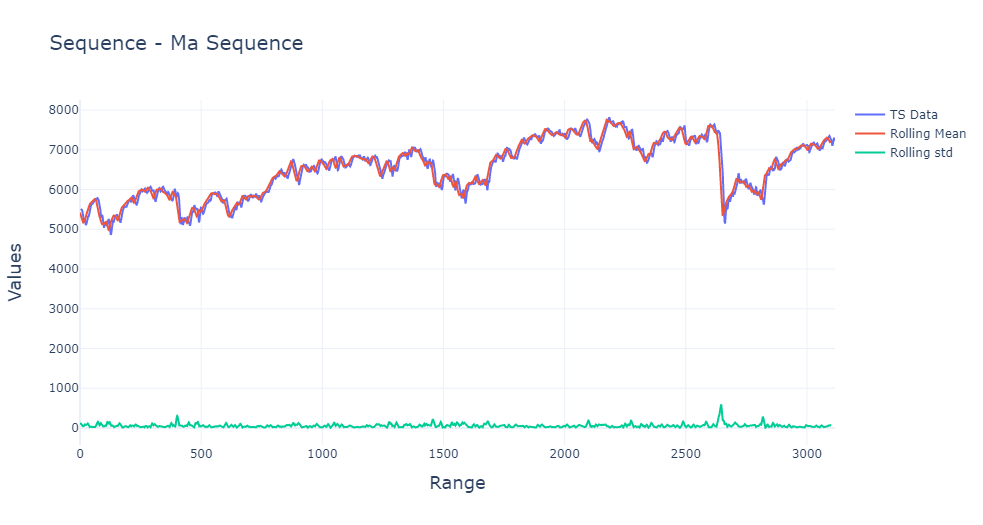

In [18]:
#====>5-day moving averages sequence
print('='*10,'5-days MA for Log Sequence','='*10)
# Transformation
df['seq_moving_avg'] = df['sequence'].rolling(window = 5, center = False).mean()
# Perform stationarity test
stat_values['5-days MA for log sequence'] = test_stationarity(df, 'seq_moving_avg', '5-days MA for log sequence', 1)
# Plot data
plot_line(df, y=['sequence', 'seq_moving_avg'], title='5-days MA for sequence')
Image('results/MLP_ (2).png')

========== Log Sequence ==========
===>Results of Dickey-Fuller Test for seq_log:

Test Statistic                   -2.619929
p-value                           0.088948
# Lags Used                       8.000000
Number of Observations Used    3237.000000
Critical Value (1%)              -3.432372
Critical Value (5%)              -2.862433
Critical Value (10%)             -2.567246
dtype: float64
Result: The series is not stationary


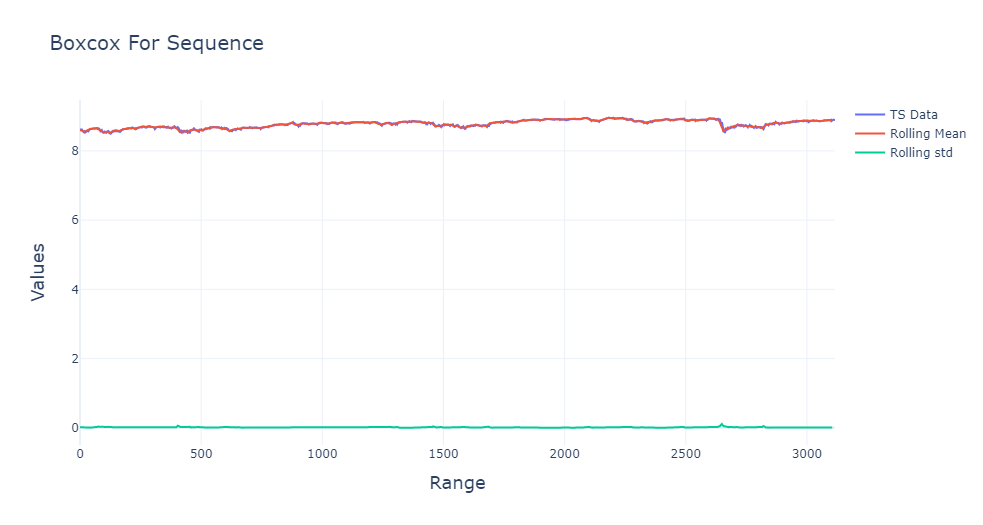

In [22]:
#====>log sequence
print('='*10,'Log Sequence','='*10)
# Transformation 
df['seq_log'] = df['sequence'].apply(lambda x: np.log(x))
# Perform stationarity test
stat_values['log sequence'] = test_stationarity(df, 'seq_log', 'sequence log', 1)
# Plot data
plot_line(df, y=['sequence', 'seq_log'], title='sequence log')
Image('results/MLP_ (3).png')

========== Boxcox for sequence ==========
===>Results of Dickey-Fuller Test for seq_boxcox:

Test Statistic                   -2.619929
p-value                           0.088948
# Lags Used                       8.000000
Number of Observations Used    3237.000000
Critical Value (1%)              -3.432372
Critical Value (5%)              -2.862433
Critical Value (10%)             -2.567246
dtype: float64
Result: The series is not stationary


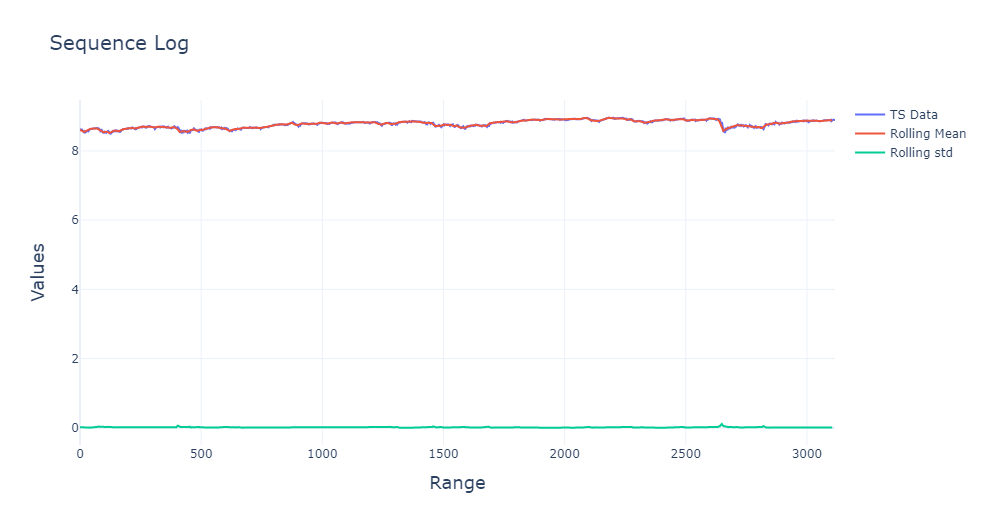

In [28]:
#====>Box-cox for sequence
print('='*10,'Boxcox for sequence','='*10)
# Transformation
df['seq_boxcox'] = boxcox(x=df['sequence'], lmbda=0.0)
# Perform stationarity test
stat_values['Boxcox for sequence'] = test_stationarity(df, 'seq_boxcox', 'Boxcox for sequence', 1)
# Plot data
plot_line(df, y=['sequence', 'seq_boxcox'], title='Boxcox for sequence')
Image('results/MLP_ (4).png')

========== Sequence - MA Sequence ==========
===>Results of Dickey-Fuller Test for seq_moving_avg:

Test Statistic                   -2.314219
p-value                           0.167423
# Lags Used                      28.000000
Number of Observations Used    3213.000000
Critical Value (1%)              -3.432387
Critical Value (5%)              -2.862440
Critical Value (10%)             -2.567249
dtype: float64
Result: The series is not stationary


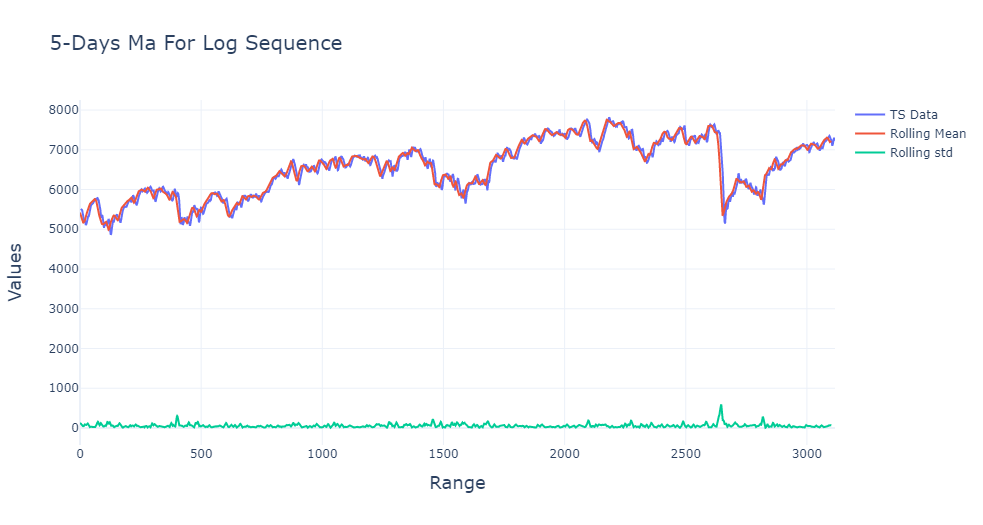

In [27]:
#====>Difference between seq and moving average seq
print('='*10,'Sequence - MA Sequence','='*10)
# Transformation 
df['seq_moving_avg_diff'] = df['sequence'] - df['seq_moving_avg']
# Perform stationarity test
stat_values['Sequence - MA Sequence'] = test_stationarity(df, 'seq_moving_avg', 'Sequence - MA Sequence', 1)
# Plot data
plot_line(df, y=['sequence', 'seq_moving_avg_diff'], title='Sequence - MA Sequence')
Image('results/MLP_ (5).png')

In [69]:
(
    pd.DataFrame(data=stat_values.values(),index=stat_values.keys()).
    sort_values(by=0,ascending=True).
    rename(columns={0:'P-Value'})
)

P-Value
sequence differencing       0.000000
log sequence                0.088948
Boxcox for sequence         0.088948
5-days MA for log sequence  0.167423
Sequence - MA Sequence      0.167423

<a href="#outlines">Back to outlines</a><br>


>#### We can apply differencing


In [31]:
df_comp = df_comp[['sequence','gdaxi','nikkei','gspc']].iloc[1:,:]

#### <a id="decomposition"></a>
<h3>Decomposition</h3><br>
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.
<ul>
<li><b>Systematic:</b> Components of the time series that have consistency or recurrence and can be described and modeled.
<li><b>Non-Systematic:</b> Components of the time series that cannot be directly modeled.<br>
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.
</ul>
These components are defined as follows:
<ul>
<li><b>Trend:</b> The increasing or decreasing value in the series.
<li><b>Seasonality:</b> The repeating short-term cycle in the series.
<li><b>Noise:</b> The random variation in the series.
</ul>

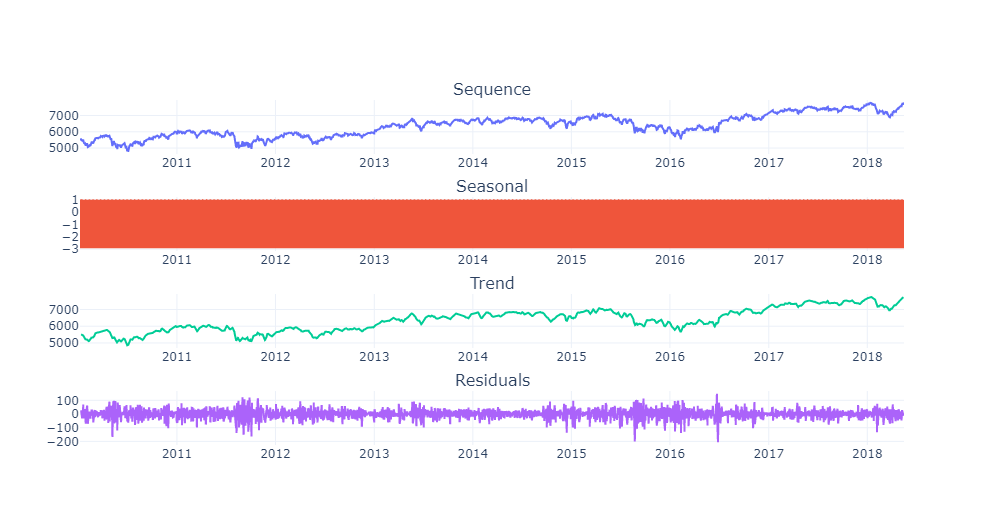

In [41]:
decomposition = seasonal_decompose(df_comp['sequence'])
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

decomposition = pd.DataFrame(index=seasonal.index)
decomposition['Sequence'] = df_comp['sequence']
decomposition['Seasonal'] = seasonal.values
decomposition['Trend'] = trend.values
decomposition['Residuals'] = resid.values

fig = make_subplots(rows=4, cols=1, subplot_titles=['Sequence','Seasonal','Trend','Residuals'], )
fig.append_trace((go.Scatter(x=decomposition.index, y=decomposition['Sequence'], showlegend=False)),1,1)
fig.append_trace((go.Scatter(x=decomposition.index, y=decomposition['Seasonal'], showlegend=False)),2,1)
fig.append_trace((go.Scatter(x=decomposition.index, y=decomposition['Trend'], showlegend=False)),3,1)
fig.append_trace((go.Scatter(x=decomposition.index, y=decomposition['Residuals'], showlegend=False)),4,1)
# fig.show()
Image('results/MLP_4.png')

> <b>WE have:</b>
> <li>A weakly seasonality in the TS.
> <li>An increasing trend.

<a id="corr"></a>
<h1>Correlation</h1><br>

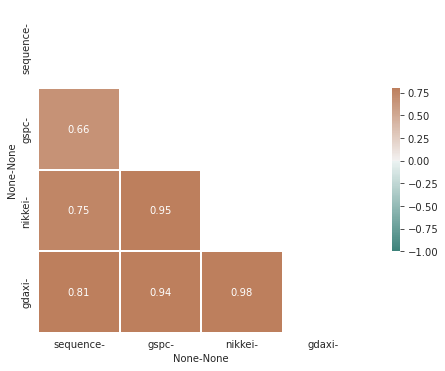

In [49]:

#correlation heatmap
corr = df_comp[['sequence','gspc','nikkei','gdaxi']].corr()

#apply a mask
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

#sett a palette
cmap = sns.diverging_palette(180, 30, as_cmap=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr,  mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=0.8,
                square=True, cbar_kws={'shrink':.5, 'orientation': 'vertical'}, linewidth=.02);

<a id="acf_pacf"></a>
<h1>Look at ACF and PACF plots</h1><br>

- **ACF:** A mathematical representation of the degree of similarity between a given time series and the lagged version of itself over successive time intervals. In other words, instead of calculating the correlation between two different series, we calculate the correlation of the series with an “x” unit lagged version (x∈N) of itself. It describes how well the present value of the series is related with its past values.
<img src='results/ACF.png'></img><br><br>
    - `r(t)` = The time series sorted in ascending order
    - `r(t-k)` = The same time series as above but shifted by K units (in our case k=3)
    - `r_bar` = Average of the original time series

<br><br><br>
- **PACF:** Summarizes the relationshi between an observation and in a TS with an observations at pevious time steps, but with relationships of the intervening obsrvations are removed.<br><br>
So, ACF measures the accumalated affects past lags have on the current value, while PACF measures the direct affect.<br><br>

- The blue area represents Significance

In [43]:
# create_corr_plot(df['sequence'], series_name='TS', plot_pacf=False)

<img src="results/MLP_5.png">

In [44]:
# create_corr_plot(df['sequence'], series_name='TS', plot_pacf=True)

<img src="results/MLP_6.png">

#### <h3>For ACF:</h3>
<ul>
    <li>All spikes are significant.
    <li>All othem are between 0.88 - 1.0.</li>
    <li>It shows that the effects are decaying over time, that means future values of the series are correlated heavily by past values.</li>
</ul>
The more lags we include, the better the model will fit the data set we feed.</b>
<h3>For PACF:</h3><ul>
    <li>Coefficient in different size.
    <li>Ther're coefficients are neg(-).
    <li>Ther're coefficients are not significant.
        </ul>


<a href="#outlines">Back to outlines</a>

<a id="forecasting"></a>
## Statistical methods Forecasting

<a id="auto_arima"></a>
<h3><u>First:</u> ARIMA Models</h3><br>

In [53]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(df_comp['gspc']['2015':'2018'], m=7, # The period for seasonal differencing(one weak)
                        exogenousdf=df_comp[['sequence','gdaxi','nikkei']]['2017':'2018'], 
                        max_p = 5, max_q = 5, max_P = 5, max_Q = 5) 

In [55]:
#Save the trained model
import pickle

# Serialize with Pickle
with open('auto_arima_pick.pkl', 'wb') as pkl:
    pickle.dump(model_auto, pkl)

# Now read it back and make a prediction
with open('auto_arima_pick.pkl', 'rb') as pkl:
    auto_arima = pickle.load(pkl)

In [56]:
auto_arima

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [57]:
arima_res = pd.DataFrame({'Auto ARIMA residuals':auto_arima.resid()})

In [58]:
# plot_line(arima_res, 'Auto ARIMA residuals', 'Auto-ARIMA Residuals')

<img src="results/MLP_7.png">

In [60]:
#plot_hist(arima_res, 'Auto-ARIMA Residuals')

<img src="results/MLP_8.png">

In [61]:
# create_corr_plot(arima_res)

 <img src="results/MLP_9.png">

 **From the residual analysis:**
- Its autocorrelation function is very week.
- Almost follow a White Noise.

so, i think we this is the best fit to the data, we didn't loss any important patterns in the data.

In [65]:
actual = df_comp['gspc']['2018':'2019'][:50]
pred = auto_arima.predict(len(actual), X=df_comp[['sequence','gdaxi','nikkei']]['2018':'2019'])
auto_pred_df = pd.DataFrame({'Actual':actual,
                            'Predictions':pred})# plot_line(auto_pred_df, ['Actual','Predictions'])

### <img src="results/MLP_10.png">

### save the data to be used in Dl notebooks

In [70]:
df.to_csv('train.csv')

df_test.to_csv('test.csv')